# **Step 1: Data Loading and Preprocessing**

In [ ]:
import pandas as pd
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import kagglehub

In [ ]:
# Load SpaCy model
#!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [ ]:
# Load datasets

# Download latest version
path = kagglehub.dataset_download("manchunhui/us-election-2020-tweets")

print("Path to dataset files:", path)
trump_path = path + "/hashtag_donaldtrump.csv"
biden_path = path + "/hashtag_joebiden.csv"
sample_size = 30000
df_trump = pd.read_csv(trump_path,
                       encoding='utf-8',
                       engine='python').sample(n=sample_size, random_state=42)
df_biden = pd.read_csv(biden_path,
                       encoding='utf-8',
                       engine='python').sample(n=sample_size, random_state=42)
df = pd.concat([df_trump, df_biden], ignore_index=True)
print(f"Number of tweets: {len(df)}")

100%|██████████| 353M/353M [00:19<00:00, 19.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/manchunhui/us-election-2020-tweets/versions/19
Number of tweets: 60000


In [ ]:
# Remove tweets that are not in English.
#!pip install langdetect
from langdetect import detect, LangDetectException

# Function to detect language.
def detect_language(text):
    # Convert input to string if it's not already.
    if not isinstance(text, str):
        text = str(text)
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Remove tweets that are not in English.
df['language'] = df['tweet'].apply(detect_language)
df = df[df['language'] == 'en']
# Show number of rows.
print(f"Number of tweets in English: {len(df)}")

Number of tweets in English: 41135


In [ ]:
# Define a function to clean the text
def clean_text(text):
    # Check if the input is a string
    if isinstance(text, str):
        text = re.sub(r"http\S+", "", text)  # Remove URLs
        text = re.sub(r"@\w+", "", text)     # Remove mentions
        text = re.sub(r"#\w+", "", text)     # Remove hashtags
        text = re.sub(r"[^A-Za-z0-9 ,.!?:']", "", text)   # Remove special characters
        return text.strip().lower()
    else:
        # Handle non-string values (e.g., NaN) by returning an empty string or another suitable value
        return ""


In [ ]:
# Ensure all tweets are strings and handle missing values
df['tweet'] = df['tweet'].fillna('').astype(str)

# Apply the cleaning function to the 'tweet' column
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Define a function to preprocess the cleaned text using SpaCy
def preprocess_text(text):
    if not text or not isinstance(text, str):
        return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [ ]:
# Apply the SpaCy preprocessing function
df['processed_tweet'] = df['clean_tweet'].apply(preprocess_text)

# Display a few rows to verify the output
df[['tweet', 'clean_tweet', 'processed_tweet']].head()

,tweet,clean_tweet,processed_tweet
0,"@JoeBiden may not know it yet, but if he troun...","may not know it yet, but if he trounces , he w...",know trounce oath new american hero delaware d...
1,#twitter #fakenews #DonaldTrump #JoeBiden #Ele...,,
3,#TrumpIsALaughingStock #StableGenius #trump ht...,,
4,@davidhogg111 Do you think #Trump will get the...,do you think will get the opportunity to pick...,think opportunity pick cell
5,@Hafsa_RG @narendramodi @JoeBiden Nothing chan...,"nothing changes for jihadists in , your optim...",change jihadist optimism misplace believer s...


# **Step 2: Sentiment Classification Models**

**1. SpaCy Text Classifier**

In [ ]:
from textblob import TextBlob

# Define a function to analyze sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    # Get the polarity
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the DataFrame
df['label_textBlob'] = df['clean_tweet'].apply(get_sentiment)

print('TextBlob labels:')
print(df['label_textBlob'].value_counts())

TextBlob labels:
label_textBlob
neutral     16798
positive    16418
negative     7886
Name: count, dtype: int64


In [ ]:

#!pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Define a function to analyze sentiment
def get_vader_sentiment(text):
    # Compute sentiment scores
    scores = sia.polarity_scores(text)
    # Determine sentiment type based on compound score
    compound = scores['compound']
    if compound > 0.05:
        return 'positive'
    elif compound < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the DataFrame
df['label_vader'] = df['clean_tweet'].apply(get_vader_sentiment)

print('VADER labels:')
print(df['label_vader'].value_counts())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


VADER labels:
label_vader
positive    15945
neutral     12761
negative    12429
Name: count, dtype: int64


In [ ]:
#!pip install transformers torch
from transformers import pipeline
sentiment_model = pipeline("sentiment-analysis")

# Define a function to analyze sentiment using the model
def get_transformer_sentiment(text):
    # Compute sentiment using the model
    result = sentiment_model(text)
    # Extract sentiment label
    #return result[0]['label'].lower()
    label_map = {'NEGATIVE': 'negative', 'NEUTRAL': 'neutral', 'POSITIVE': 'positive'}
    return label_map[result[0]['label']]

# Apply the function to the DataFrame
df['label_transformers'] = df['clean_tweet'].apply(get_transformer_sentiment)

print('Transformers labels:')
print(df['label_transformers'].value_counts())



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Transformers labels:
label_transformers
negative    23740
positive    17380
Name: count, dtype: int64


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Initialize the sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Define a function to analyze sentiment using the model
def get_roberta_sentiment(text):
    # Compute sentiment using the model
    result = sentiment_pipeline(text)
    # From documentation: Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive
    label_map = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}
    return label_map[result[0]['label']]


# Apply the function to the DataFrame
df['label_roberta'] = df['processed_tweet'].apply(get_roberta_sentiment)

print('Roberta labels:')
print(df['label_roberta'].value_counts())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Roberta labels:
label_roberta
neutral     25002
negative    11672
positive     4498
Name: count, dtype: int64


In [ ]:
import spacy
from sklearn.metrics import accuracy_score, classification_report

nlp = spacy.blank("en")
textcat = nlp.add_pipe("textcat")
textcat.add_label("positive")
textcat.add_label("negative")
textcat.add_label("neutral")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


1

**2. SVM, 3. Random Forest, and 4. Logistic Regression**

In [ ]:
# Convert the processed tweets to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_tweet']).toarray()
y = df['label_vader']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# SVM Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.7852979274611399
SVM Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.61      0.69      3566
     neutral       0.78      0.91      0.84      7448
    positive       0.78      0.56      0.65      1338

    accuracy                           0.79     12352
   macro avg       0.79      0.69      0.73     12352
weighted avg       0.79      0.79      0.78     12352



In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7763924870466321
Random Forest Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.63      0.69      3566
     neutral       0.79      0.88      0.83      7448
    positive       0.72      0.57      0.63      1338

    accuracy                           0.78     12352
   macro avg       0.76      0.69      0.72     12352
weighted avg       0.77      0.78      0.77     12352



In [ ]:
# Logistic Regression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_pred_lr = log_reg_model.predict(X_test)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7852169689119171
Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.62      0.70      3566
     neutral       0.78      0.91      0.84      7448
    positive       0.81      0.54      0.65      1338

    accuracy                           0.79     12352
   macro avg       0.79      0.69      0.73     12352
weighted avg       0.79      0.79      0.78     12352



# **Step 3: Clustering Models**

**1. K-means Clustering**

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X)
df['kmeans_cluster'] = clusters_kmeans

print("KMeans Clustering - Cluster Counts:")
print(df['kmeans_cluster'].value_counts())

KMeans Clustering - Cluster Counts:
kmeans_cluster
4    9933
1    1250
0     951
2     734
3     710
Name: count, dtype: int64


2. **DBSCAN**

In [ ]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X)
df['dbscan_cluster'] = clusters_dbscan

print("\nDBSCAN Clustering - Cluster Counts (including noise):")
print(df['dbscan_cluster'].value_counts())


DBSCAN Clustering - Cluster Counts (including noise):
dbscan_cluster
-1     11737
 0      1209
 4        48
 35       42
 3        24
       ...  
 40        5
 68        5
 41        5
 16        5
 47        5
Name: count, Length: 72, dtype: int64


In [ ]:
# Handle -1 (noise) for DBSCAN
df['dbscan_cluster'] = df['dbscan_cluster'].apply(lambda x: 'Noise' if x == -1 else f'Cluster {x}')

**3. Hierarchical Clustering**

In [ ]:
# **3. Hierarchical Clustering**
hierarchical = AgglomerativeClustering(n_clusters=5)
clusters_hierarchical = hierarchical.fit_predict(X)
df['hierarchical_cluster'] = clusters_hierarchical

print("\nHierarchical Clustering - Cluster Counts:")
print(df['hierarchical_cluster'].value_counts())


Hierarchical Clustering - Cluster Counts:
hierarchical_cluster
1    12996
0      294
2      195
3       50
4       43
Name: count, dtype: int64


**4. Latent Dirichlet Allocation (LDA)**

In [ ]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_features = lda.fit_transform(X)

# Assign topics to each tweet based on the highest topic probability
df['lda_topic'] = lda_features.argmax(axis=1)
print("\nLDA Topic Modeling - Topic Counts:")
print(df['lda_topic'].value_counts())


LDA Topic Modeling - Topic Counts:
lda_topic
0    4011
3    2547
1    2540
4    2420
2    2060
Name: count, dtype: int64


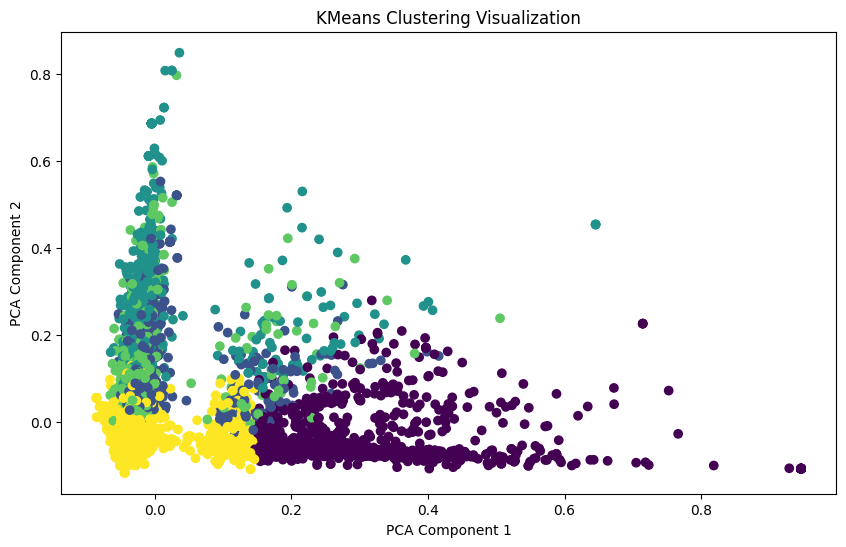

In [ ]:
# **Visualize KMeans Clusters using PCA**
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters_kmeans, cmap='viridis')
plt.title("KMeans Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# **Step 4: Evaluation and Visualization**

**Classification Evaluation**

In [ ]:
# 1. Model Evaluation Reports
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


SVM Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.65      0.68      1207
     neutral       0.74      0.85      0.79      1259
    positive       0.80      0.75      0.77      1608

    accuracy                           0.75      4074
   macro avg       0.75      0.75      0.75      4074
weighted avg       0.75      0.75      0.75      4074


Random Forest Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.60      0.65      1207
     neutral       0.75      0.85      0.80      1259
    positive       0.76      0.76      0.76      1608

    accuracy                           0.74      4074
   macro avg       0.74      0.74      0.73      4074
weighted avg       0.74      0.74      0.74      4074


Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.65      0.68      1207
     neutral    

In [ ]:
# 2. Visualize K-means Clusters using PCA
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

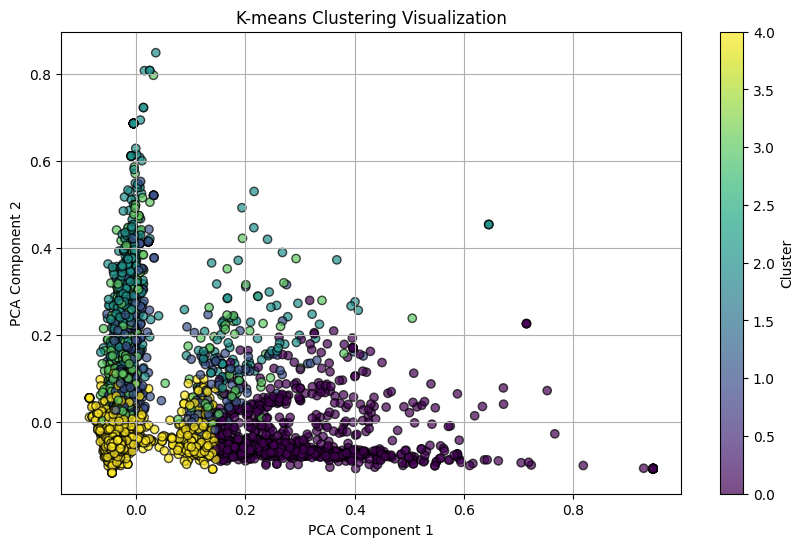

In [ ]:
# Plot K-means clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=clusters_kmeans,
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title("K-means Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

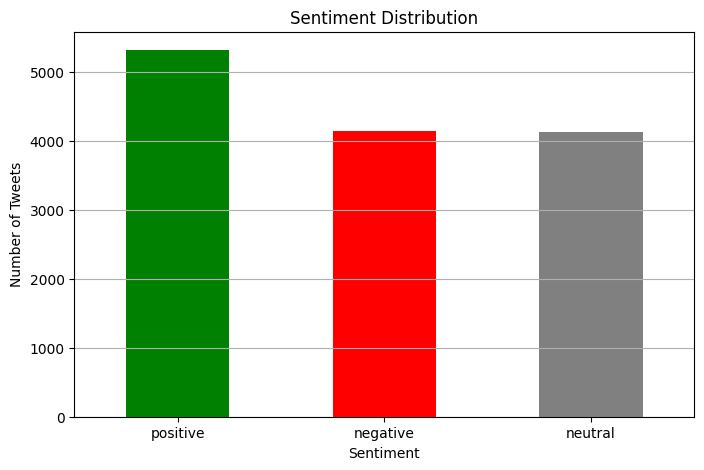

In [ ]:
# 3. Visualize Sentiment Distribution
plt.figure(figsize=(8, 5))
df['label_vader'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

**Clustering Visualization**

# **Step 5: Time Series Analysis**

In [ ]:
# Convert the 'created_at' column to datetime format, handling any errors
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Drop rows where 'created_at' conversion failed (NaT values)
df = df.dropna(subset=['created_at'])

# Group by date and sentiment, then unstack to create separate columns for each sentiment
sentiment_over_time = df.groupby([df['created_at'].dt.date, 'label_vader']).size().unstack(fill_value=0)

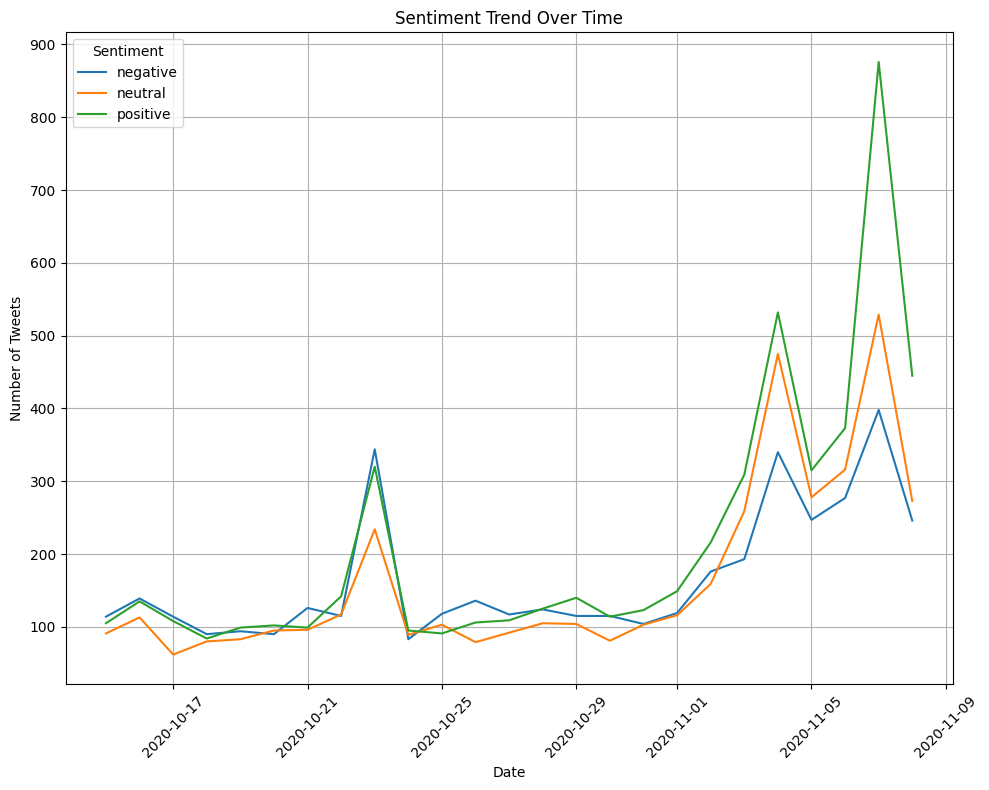

In [ ]:
# Plotting the sentiment trends over time
plt.figure(figsize=(10, 8))
for sentiment in sentiment_over_time.columns:
    plt.plot(sentiment_over_time.index, sentiment_over_time[sentiment], label=sentiment)

plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Step 6: Project Report**

**1. Introduction**

The goal of this project was to analyze tweets related to Donald Trump and Joe Biden, using text analysis techniques to:

* Perform sentiment analysis using various classification models.
* Perform topic clustering using different clustering algorithms.
* Conduct time series analysis to understand sentiment trends over time.

**2. Data Preprocessing**
* We utilized SpaCy for text cleaning and lemmatization, which helped convert tweets into a format suitable for analysis.
* Tweets were preprocessed to remove URLs, mentions, hashtags, and special characters. This was followed by tokenization and lemmatization.


--------------------------------------------------------------------------------

**3. Sentiment Analysis Results**

**Labelling**

We tried three differetn methods for labelling the data. They produced somewhat similar distributions of positive, negative and neutral sentiments:

* TextBlob Method:<br>
Neutral: 40.87%
Positive: 39.94%
Negative: 19.19%

* VADER Method: <br>
Positive: 38.76%
Neutral: 31.02%
Negative: 30.22%

* RoBERTa Method:<br>
Neutral: 60.73%
Negative: 28.35%
Positive: 10.92%

We have used labels produced by the VADER method for the following classification models since this method offered the most balanced distribution of labels. Also, Vader method is considered the most effective for labeling social media data since it is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

**Classification**

We used three classification models: SVM, Random Forest, and Logistic Regression.

**Observations:**

* All three models performed at about 79% accuracy, indication no particular advantage of one model over the other for this particular data.
* The f1-scores, which balance precision and recall, are also similar across the models.
* The three classes "positive", "negative", and "neutral" had about even distribution of tweets in the original data according to VADER classification model, at 38.76%, 30.22%, and 31.02% respectively.
* All models have a slightly lower performance on the negative class compared to neutral and positive, with f1-scores around 0.65 to 0.68. This might indicate a slightly more challenging nature of classifying negative sentiments.
* The neutral sentiment classification is relatively better for all models, particularly in terms of recall (0.85 for SVM and Logistic Regression), suggesting these models are more capable of identifying neutral sentiments.
* The positive sentiment shows good precision and recall across all models, with f1-scores around 0.76 to 0.77 for SVM and Logistic Regression.

--------------------------------------------------------------------------------

**4. Clustering Results**

We used four different clustering techniques: KMeans, DBSCAN, Agglomerative Clustering, and LDA Topic Modeling.

**KMeans Clustering:**

* The data points are distributed mainly across four distinct clusters. The presence of multiple clusters suggests varying groups within the dataset that the K-means algorithm has identified based on the similarity of data points within each group.

**DBSCAN Clustering:**

* Majority of the tweets were classified as noise (-1), 11,737 tweets. This high count of noise points suggests that a large portion of the dataset does not fit well into any dense cluster.
* Cluster 0 was the largest distinct cluster with 1,209 tweets.
* The presence of many smaller clusters suggests that there are groupings in the tweets, though they are much less dense or smaller in size compared to Cluster 0.

**Hierarchical Clustering:**

* Cluster 1 had the highest number of tweets (12,996).
* Other clusters were significantly smaller.

**LDA Topic Modeling:**

* The top topics identified were:

Topic 0: 4,011 tweets

Topic 1: 2,540 tweets

Topic 2: 2,060 tweets

Topic 3: 2,547 tweets

Topic 4: 2,420 tweets



**Observations:**

* The KMeans clustering model performed the best in terms of separating tweets into distinct groups.
* DBSCAN struggled with noise, indicating that many tweets might not fit neatly into a cluster.
* LDA was effective for extracting topics, which can be useful for understanding the main themes in the tweets.

--------------------------------------------------------------------------------

**5. Time Series Analysis**

We analyzed sentiment trends over time to see how public opinion changed during the specified period.

* Notable peaks occur across all sentiments with an especially sharp rise in positive sentiment in early November. These could be tied to specific events or public announcements that elicited strong public reactions on Twitter.
* Cross over of positive and negative sentiments at certain points of time potentially indicates polarizing events where public opinions were strongly divided.

**Observations:**

* The spikes suggest that tweet volumes and their sentiments are heavily influenced by specific dates or events. Analyzing these points with real-world events can provide insights into public sentiment on significant matters such as political announcements, societal issues, or global events.
* Understanding these patterns could be valuable for predictive modeling, such as anticipating public sentiment trends based on scheduled events or recurring phenomena.


--------------------------------------------------------------------------------

**6. Conclusion**

In this project, we aimed to understand public sentiments towards Donald Trump and Joe Biden by analyzing tweets using various data analysis methods. We cleaned and preprocessed the tweets using SpaCy, which prepared them for detailed examination. Our sentiment analysis, using SVM, Random Forest, and Logistic Regression, showed an overall accuracy of about 79% across all models, indicating a balanced performance in detecting positive, negative, and neutral sentiments. The clustering techniques, especially KMeans, effectively grouped the tweets, revealing diverse public opinions. Time series analysis highlighted significant shifts in sentiment during key events, suggesting that public opinion on Twitter is strongly influenced by ongoing events. This comprehensive analysis not only shed light on the general public's sentiment but also demonstrated the potential of text analysis in gauging public mood and opinion in real-time.